# 1.) Import Dependencies

In [45]:
#screen cap
from mss import mss
#commands
import pydirectinput
#frame processing
import cv2
#transformational framework
import numpy as np
#OCR for game over detection
#import pytesseract
#from pytesseract import image_to_string
import pyautogui
#visualize captured frames
from matplotlib import pyplot as plt
#pauses
import time 
#enviroment 
from gym import Env
from gym.spaces import Box, Discrete
#random names for models
from faker import Faker
from faker_biology.bioseq import Bioseq

# 2.) Enviroment Setup

In [52]:
class dinogame(Env):
    #set tesseract path 
    #ytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'
    
    #setup enviroment action and observation shapes
    def __init__(self):
        #subclass model
        super().__init__()
        #setup spaces 
        self.observation_space = Box(low = 0, high = 255, shape=(1, 83, 100), dtype = np.uint8)
        self.action_space = Discrete(3)
        #define extraction parameters for the game
        self.cap = mss()
        self.game_location = {'top': 300, 'left': 0, 'width': 600, 'height': 500,}
        self.done_location = {'top': 375, 'left': 630, 'width': 660, 'height': 80,}
    
        pass
    #called to do action in game
    def step(self, action):
        #Action key:
            #0 = space 
            #1 = duck 
            #2 = no action
            
        action_map= {
            0: 'space',
            1: 'down',
            2: 'no_op',
        }
        if action != 2:
            pydirectinput.press(action_map[action])
            
        #check if game is done
        done, done_cap = self.get_done()
        #check new observation
        new_observation = self.get_observation()
        #reward - awarded point for every frame alive
        reward = 1
        #info dictionary
        info = {}
        
        return new_observation, reward, done, info 
    
    #visualize game
    def render(self):
        cv2.imshow('Game', np.array(self.cap.grab(self.game_location))[:, :, :3])
        if cv2.waitKey(1) & 0xFF == ord('q'):
            self.close()
    
    #restart game
    def reset(self):
        time.sleep(1)
        pydirectinput.click(x = 150, y = 150)
        pydirectinput.press('space')
        return self.get_observation()
    
    #stops observation
    def close(self):
        cv2.destroyAllWindows()
    
    #get part of game that we want
    def get_observation(self):
        #get screen cap of game 
        raw = np.array(self.cap.grab(self.game_location))[:, :, :3]
        #grayscale
        gray = cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY)
        #resize
        resized = cv2.resize(gray, (100, 83))
        #add channels 
        channel = np.reshape(resized, (1, 83, 100))
        return channel
    
    #tell if game is over    
    def get_done(self):
        #get game over 
        done_cap = np.array(self.cap.grab(self.done_location))[:, :, :3]
        #valid done text 
        #done_strings = ['GAME', 'GAHE', 'Wir ', 'WHT ', 'YWHi', 'Wor ', '41 F']

        #apply OCR
        done = True 
        #res = pytesseract.image_to_string(done_cap)[:4]
        if pyautogui.locateCenterOnScreen('dino.png') is None:
            done = False
              
        return done, done_cap, 

# 3.)Test Enviroment 

In [53]:
env = dinogame()

In [54]:
obs = env.get_observation()

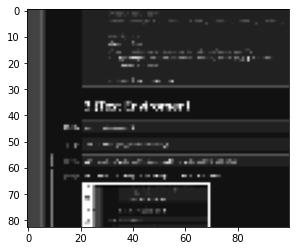

In [55]:
plt.imshow(cv2.cvtColor(obs[0], cv2.COLOR_BGR2RGB))

In [56]:
done, done_cap = env.get_done()
print(done)

False


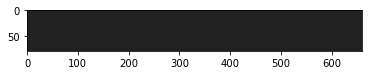

In [57]:
plt.imshow(done_cap)

# 4.) Setup Directories and Check Enviroment

In [11]:
#file path management
import os 
#check enviroment
from stable_baselines3.common import env_checker 

In [13]:
#prevent errors
pydirectinput.FAILSAFE = False

In [14]:
#check enviroment is ok
env_checker.check_env(env)

In [15]:
CHECKPOINT_DIR = './train/'
LOG_DIR = './logs/'

# 5.) Build New Model and Train

# 5.1) Train on DQN Algo

In [30]:
# import DQN algo
from stable_baselines3 import DQN
#saving models
from stable_baselines3.common.callbacks import BaseCallback

In [31]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [32]:
callback = TrainAndLoggingCallback(check_freq = 1000, save_path = CHECKPOINT_DIR + 'DQN')

In [ ]:
#create DQN model
model = DQN('CnnPolicy', env, learning_rate=0.0001, tensorboard_log=LOG_DIR, verbose=1, buffer_size=50000, learning_starts=1000 )

In [ ]:
#start training 
model.learn(total_timesteps=88000, callback=callback)

# 5.2) Train PPO Algo (kinda sucks)

In [ ]:
#import PPO algo
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnRewardThreshold

In [ ]:
save_path = os.path.join('models/PPO')

In [ ]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [ ]:
callback = TrainAndLoggingCallback(check_freq = 10000, save_path = CHECKPOINT_DIR + 'PPO')

In [ ]:
model = PPO('MlpPolicy', env, verbose=1, tensorboard_log=LOG_DIR)

In [ ]:
model.learn(total_timesteps=100000, callback=callback)

# 6.) Load and Re-Train model

In [77]:
#setup naming convention
fake = Faker()
fake.add_provider(Bioseq)

In [78]:
#change hyperparameters
custom_objects = {'learning_rate': 0.0001}

In [79]:
#load model (without ".zip" extension)
model = DQN.load(os.path.join('models/DQN/model_PSG3.zip'), custom_objects = custom_objects)

In [80]:
#set model enviroment 
model.set_env(env)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [43]:
#start training 
model.learn(total_timesteps=10000, callback=callback, reset_num_timesteps=False)

TypeError: learn() got an unexpected keyword argument 'total_episodes'

In [70]:
model.save('models/DQN/model_' +  fake.protein_name()[:4])

# 7.) Load/Test Model


In [20]:
#import required libraries
from stable_baselines3 import DQN
import os 

In [21]:
model = DQN.load(os.path.join('models/DQN/model_PSG3.zip'))

In [22]:
#play 10 games
for episode in range(1):
    obs = env.reset()
    done = False 
    total_reward = 0
    
    while not done:
        action, _ = model.predict(obs)
        obs, reward, done, info = env.step(int(action))
        time.sleep(0.01)
        total_reward += reward
    print(f'Total Reward for episode {episode} is {total_reward}')
    time.sleep(2)

Total Reward for episode 0 is 28
